In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Load the cleaned dataset
df = pd.read_csv("swiss_no_outliers_and_cleaned.csv")

# Select features and target variable
X = df[["Rooms", "Footage", "Distance_to_City_Center(km)", "Address_Latitude", "Address_Longitude"]]
y = df["Rent"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the input layer
input_data = Input(shape=(5,))

# Define the encoder
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

# Define the bottleneck (compressed representation)
bottleneck = Dense(8, activation='relu')(encoded)

# Define the decoder
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)

# Define the output layer
output_data = Dense(5, activation='linear')(decoded)

# Create the autoencoder model
autoencoder = Model(input_data, output_data)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder model
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Extract the encoder part of the autoencoder
encoder = Model(input_data, bottleneck)

# Generate a lower-dimensional representation of your input data
X_encoded_train = encoder.predict(X_train_scaled)
X_encoded_test = encoder.predict(X_test_scaled)

def create_model(model_type, units, dropout_rate, learning_rate):
    model = Sequential()

    if model_type == "MLP":
        model.add(Dense(units, input_shape=(X_encoded_train.shape[1],), activation='relu'))
        model.add(Dropout(dropout_rate))
    elif model_type == "DNN":
        model.add(Dense(units, input_shape=(X_encoded_train.shape[1],), activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    elif model_type == "CNN":
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_encoded_train.shape[1],1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

# Wrap the create_model function in KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model_type': ['MLP', 'DNN', 'CNN'],
    'units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit the random search to the data
random_search_result = random_search.fit(X_encoded_train, y_train)

# Print the best hyperparameters
print("Best parameters found: ", random_search_result.best_params_)

# Retrieve the best model
best_model = random_search_result.best_estimator_.model
best_model.save("best_model.h5")

# Make predictions
y_pred_train = best_model.predict(X_encoded_train)
y_pred_test = best_model.predict(X_encoded_test)

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print the results
print("Best model:")
print(f" MSE (Train): {mse_train:.2f}")
print(f" MSE (Test): {mse_test:.2f}")
print(f" R2 (Train): {r2_train:.2f}")
print(f" R2 (Test): {r2_test:.2f}")


Epoch 1/100
169/169 [==============================] - 1s 2ms/step - loss: 0.6215 - val_loss: 0.1849
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 0.2422 - val_loss: 0.0581
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0931 - val_loss: 0.0170
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0822 - val_loss: 0.0124
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0458 - val_loss: 0.0217
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0085
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0090
Epoch 8/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0512 - val_loss: 0.0833
Epoch 9/100
169/169 [==============================] - 0s 1ms/step - loss: 0.1262 - val_loss: 0.0091
Epoch 10/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0452 - val_lo

C:\Users\remy\AppData\Local\Temp\ipykernel_812\1894225690.py:83: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best parameters found:  {'units': 128, 'model_type': 'MLP', 'learning_rate': 0.01, 'epochs': 150, 'dropout_rate': 0.3, 'batch_size': 32}
53/53 [==============================] - 0s 562us/step
Best model:
 MSE (Train): 2160968.51
 MSE (Test): 2086192.92
 R2 (Train): -6.25
 R2 (Test): -6.45


In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fit a Linear Regression model to the true and predicted values
linear_reg = LinearRegression()
y_train_reshaped = y_train.values.reshape(-1, 1)
y_pred_train_reshaped = y_pred_train.reshape(-1, 1)
linear_reg.fit(y_train_reshaped, y_pred_train_reshaped)

# Predict the values using the linear regression model
y_pred_linear_reg = linear_reg.predict(y_train_reshaped)

# Create the scatter plot
plt.scatter(y_train_reshaped, y_pred_train_reshaped, color='blue', alpha=0.5)
plt.plot(y_train_reshaped, y_pred_linear_reg, color='red')

# Add the labels and title
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Rent Values - Training Data")

# Show the plot
plt.show()



AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Load the cleaned dataset
df = pd.read_csv("swiss_no_outliers_and_cleaned.csv")

# Select features and target variable
X = df[["Rooms", "Footage", "Distance_to_City_Center(km)", "Address_Latitude", "Address_Longitude"]]
y = df["Rent"]

# Scale the input and target data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(np.array(y).reshape(-1,1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, timesteps, features] for CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def create_model(learning_rate=0.001, dropout_rate=0.2):
 model = Sequential()
 model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
 model.add(Dropout(dropout_rate))
 model.add(Dense(64, activation='relu'))
 model.add(Dense(1))
 model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
 return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
 'learning_rate': [0.01, 0.001, 0.0001],
 'dropout_rate': [0.1, 0.2, 0.3],
 'epochs': [50, 100, 200],
 'batch_size': [16, 32, 64],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', random_state=42)
random_search_result = random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search_result.best_params_)


best_model = random_search_result.best_estimator_.model
best_model.save("best_model.h5")




C:\Users\remy\AppData\Local\Temp\ipykernel_812\3795953524.py:40: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best parameters found:  {'learning_rate': 0.01, 'epochs': 100, 'dropout_rate': 0.2, 'batch_size': 16}


In [20]:

from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_model.h5")

# Make predictions
y_pred_train = best_model.predict(X_train_scaled) # Make sure to use the scaled version
y_pred_test = best_model.predict(X_test_scaled)  # Make sure to use the scaled version

# Inverse transform the predictions to original scale 
y_pred_train_original = scaler_y.inverse_transform(y_pred_train) 
y_pred_test_original = scaler_y.inverse_transform(y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train_original) # Calculate MSE using the inverse transformed predictions
mse_test = mean_squared_error(y_test, y_pred_test_original)   # Calculate MSE using the inverse transformed predictions
r2_train = r2_score(y_train, y_pred_train_original)  # Calculate R2 using the inverse transformed predictions
r2_test = r2_score(y_test, y_pred_test_original)   # Calculate R2 using the inverse transformed predictions

print("Best model:")
print(f" MSE (Train): {mse_train:.2f}")
print(f" MSE (Test): {mse_test:.2f}")
print(f" R2 (Train): {r2_train:.2f}")
print(f" R2 (Test): {r2_test:.2f}")


53/53 [==============================] - 0s 577us/step
Best model:
 MSE (Train): 2872061.02
 MSE (Test): 2871408.47
 R2 (Train): -87263964.25
 R2 (Test): -92917623.25


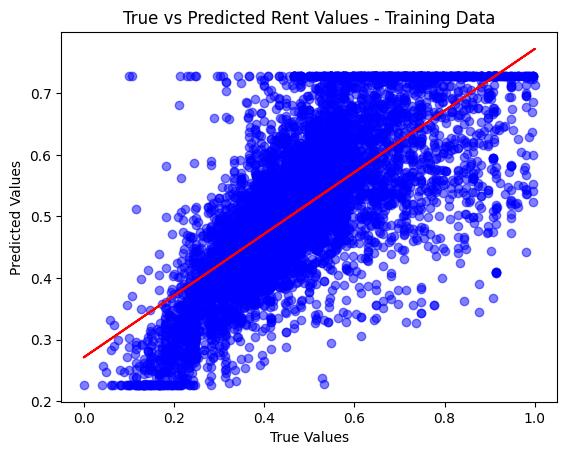

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fit a Linear Regression model to the true and predicted values
linear_reg = LinearRegression()

# Reshape y_train and y_pred_train
y_train_reshaped = y_train.reshape(-1, 1)
y_pred_train_reshaped = y_pred_train.reshape(-1, 1)

# Fit the model
linear_reg.fit(y_train_reshaped, y_pred_train_reshaped)

# Predict the values using the linear regression model
y_pred_linear_reg = linear_reg.predict(y_train_reshaped)

# Create the scatter plot
plt.scatter(y_train_reshaped, y_pred_train_reshaped, color='blue', alpha=0.5)
plt.plot(y_train_reshaped, y_pred_linear_reg, color='red')

# Add the labels and title
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Rent Values - Training Data")

# Show the plot
plt.show()


In [21]:
#should be about 11
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the cleaned dataset
df = pd.read_csv("swiss_no_outliers_and_cleaned.csv")

# Select features and target variable
X = df[["Rooms", "Footage", "Distance_to_City_Center(km)", "Address_Latitude", "Address_Longitude"]]
y = df["Rent"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Define the input layer
input_data = Input(shape=(5,))

# Define the encoder
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

# Define the bottleneck (compressed representation)
bottleneck = Dense(8, activation='relu')(encoded)

# Define the decoder
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)

# Define the output layer
output_data = Dense(5, activation='linear')(decoded)

# Create the autoencoder model
autoencoder = Model(input_data, output_data)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Extract the encoder part of the autoencoder
encoder = Model(input_data, bottleneck)

# Generate a lower-dimensional representation of your input data
X_encoded = encoder.predict(X_scaled)

# Reshape the encoded data into a suitable format for RNNs, LSTMs, or GRUs
timesteps = 2
features = 4
X_encoded_reshaped = X_encoded.reshape((-1, timesteps, features))

# Split the reshaped data into training and testing sets
X_encoded_train, X_encoded_test, y_train, y_test = train_test_split(X_encoded_reshaped, y_train, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(model_type, units):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(units, activation='relu'))
        model.add(Dropout(0.2))
    elif model_type == "LSTM":
        model.add(LSTM(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units, activation='relu'))
        model.add(Dropout(0.2))
    elif model_type == "GRU":
        model.add(GRU(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(units, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model


# Define the parameter grid
param_grid = {
    'model_type': ['RNN', 'LSTM', 'GRU'],
    'units': [ 128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.05, 0.01, 0.005],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150],
}


# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit the random search to the data
random_search_result = random_search.fit(X_encoded_train, y_train)

# Print the best hyperparameters
print("Best parameters found: ", random_search_result.best_params_)

# Retrieve the best model
best_model = random_search_result.best_estimator_.model
best_model.save("best_model.h5")

# Make predictions
y_pred_train = best_model.predict(X_encoded_train)
y_pred_test = best_model.predict(X_encoded_test)

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print the results
print("Best model:")
print(f" MSE (Train): {mse_train:.2f}")
print(f" MSE (Test): {mse_test:.2f}")
print(f" R2 (Train): {r2_train:.2f}")
print(f" R2 (Test): {r2_test:.2f}")



Epoch 1/100
169/169 [==============================] - 1s 2ms/step - loss: 0.5371 - val_loss: 0.1621
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 0.1502 - val_loss: 0.0356
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0926 - val_loss: 0.0408
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0413 - val_loss: 0.0121
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0070
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0130
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0980 - val_loss: 0.0090
Epoch 8/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0083
Epoch 9/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0214 - val_loss: 0.0067
Epoch 10/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0434 - val_lo

ValueError: units is not a legal parameter

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the best model
best_model = load_model("best_model.h5")

# Predict the values using the best model
y_pred_train = best_model.predict(X_encoded_train)
y_pred_test = best_model.predict(X_encoded_test)

# Fit a Linear Regression model to the true and predicted values
linear_reg = LinearRegression()
y_train_reshaped = y_train.values.reshape(-1, 1)
y_pred_train_reshaped = y_pred_train.reshape(-1, 1)
linear_reg.fit(y_train_reshaped, y_pred_train_reshaped)

# Predict the values using the linear regression model
y_pred_linear_reg = linear_reg.predict(y_train_reshaped)

# Create the scatter plot
plt.scatter(y_train_reshaped, y_pred_train_reshaped, color='blue', alpha=0.5)
plt.plot(y_train_reshaped, y_pred_linear_reg, color='red')

# Add the labels and title
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Rent Values - Training Data")

# Show the plot
plt.show()
